# NLP Overview

This is the notebook for my medium article analyzing Indeed Data Analyst job postings. First step is to import and read files, create new columns, and clean the text column of unwanted data (i.e. unrecognized characters)

In [3]:
import pandas as pd
import numpy as np
import datetime
import re
from tqdm import tqdm

'''preprocessing'''
corpus = pd.read_csv(r'C:\Users\Andrew\Documents\PythonScripts\NLP\webscraping\Indeed Job Postings\datajobs.csv',index_col=0)
corpus = corpus.applymap(lambda x: x.strip())
corpus["City"] = corpus["Location"].apply(lambda x: x.split(',')[0])
corpus["State"] = corpus["Location"].apply(lambda x: x.split(',')[1].split(' ')[1])

import string
def remove_weird_letters(x):
    new_string = ""
    accepted_char = list(string.ascii_lowercase) + list(string.ascii_uppercase) + list(string.punctuation) + list(" ")
    
    for letter in x:
        for char in accepted_char:
            if char in letter:
                new_string = new_string + char
                break
    return new_string

corpus["Summary"] = corpus["Summary"].apply(lambda x: remove_weird_letters(x))

corpus.head(5)

,Job Title,Location,Company,URL,Summary,City,State
0,Data Analyst new,"Brooklyn, NY 11201",TuneCore,/rc/clk?jk=1ad24eba2cc898b0&fccid=261c0771a0ed...,Job Description Job Purpose: TuneCore is seek...,Brooklyn,NY
1,eCommerce Data Analyst,"New York, NY 10280 (Battery Park area)",Fair Harbor,/rc/clk?jk=76d5bff104ea7e20&fccid=b66bfc184e5a...,About Fair Harbor Fair Harbor makes ultra-comf...,New York,NY
2,Data Analyst new,"New York, NY",TeePublic,/rc/clk?jk=90bb410e5296aa5a&fccid=665f8f7bb3fc...,"TeePublic, the world's fastest growing communi...",New York,NY
3,Data Analyst new,"New York, NY",US Department of Homeland Security,/rc/clk?jk=eb1c6aa226586bb7&fccid=e3977494b2eb...,Duties Summary This position is being announce...,New York,NY
4,Data Analyst,"New York, NY",Bodhala,/rc/clk?jk=4f848b9c2a2ea0aa&fccid=6e7de84a2f52...,Bodhalas groundbreaking legal technology solut...,New York,NY


### Next, we tokenize using nltk and apply two sklearn transformers to create a spare weighted word matrix.

In [4]:
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize
from sklearn.feature_extraction.text import CountVectorizer #acts like a model pretty much

stop_words = stopwords.words("english")
lemmatizer = WordNetLemmatizer()

def tokenize(text):
    # normalize case and remove punctuation
    text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower())
    
    # tokenize text
    tokens = word_tokenize(text)
    
    # lemmatize andremove stop words
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]

    return tokens
# initialize count vectorizer object
vect = CountVectorizer(tokenizer=tokenize)
X = vect.fit_transform(corpus["Summary"]) # [] needs to be wrapped around the string to make it a "document" if you select single element
vect.vocabulary_

from sklearn.feature_extraction.text import TfidfTransformer

# initialize tf-idf transformer object
transformer = TfidfTransformer(smooth_idf=False)
tfidf_X = transformer.fit_transform(X)

print('done')

done


### We can visualize this in a PCA like this:

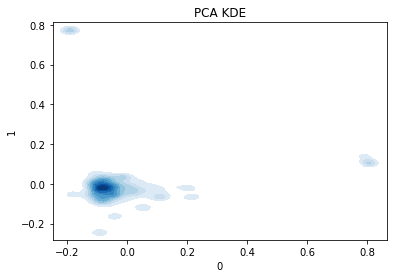

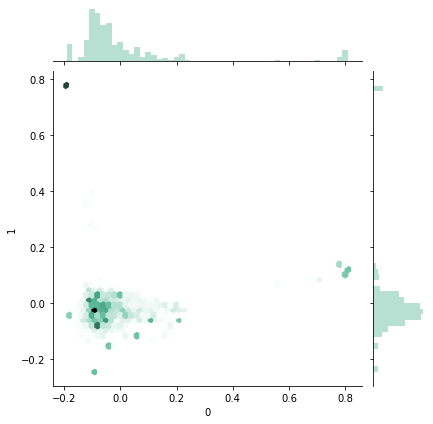

In [8]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, KernelPCA
clust_df = pd.DataFrame(data=tfidf_X.toarray()) 
clust_df.columns = vect.vocabulary_

pca = PCA(n_components=20)
principalComponents = pca.fit_transform(clust_df) #replace with cosine or clust_df

PCA_components = pd.DataFrame(principalComponents)
PCA_components["Company"] = corpus["Company"]
PCA_components["Location"] = corpus["Location"]
PCA_components["State"] = corpus["State"]
PCA_components["Summary"] = corpus["Summary"]
PCA_components["Size"] = 1

import seaborn as sns
import matplotlib.pyplot as plt

ax = sns.kdeplot(PCA_components[0], PCA_components[1], shade=True, cmap = 'Blues',shade_lowest=False).set(title="PCA KDE")
ax = sns.jointplot(PCA_components[0], PCA_components[1], kind="hex", color="#4CB391")

### Since that PCA didn't tell us too much, we create a soft cosine matrix:

In [9]:
import time
import gensim
import gensim.downloader as api
from gensim.utils import simple_preprocess
from gensim.corpora import Dictionary
from gensim.models import Word2Vec, WordEmbeddingSimilarityIndex
from gensim.similarities import SoftCosineSimilarity, SparseTermSimilarityMatrix

fasttext = api.load('fasttext-wiki-news-subwords-300')
termsim_index = WordEmbeddingSimilarityIndex(fasttext.wv)

dictionary = Dictionary([simple_preprocess(doc) for doc in corpus["Summary"]]) 
bow_corpus = [dictionary.doc2bow(simple_preprocess(document)) for document in corpus["Summary"]]

similarity_matrix = SparseTermSimilarityMatrix(termsim_index, dictionary)
docsim_index = SoftCosineSimilarity(bow_corpus, similarity_matrix)#, num_best=10)

sims = docsim_index[bow_corpus]
cosine = pd.DataFrame(data=sims)
cosine = cosine.applymap(lambda x: round(x,4))

print(cosine.iloc[:5,:5])

C:\Anaconda3\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  app.launch_new_instance()


        0       1       2       3       4
0  1.0000  0.8472  0.8967  0.8144  0.8662
1  0.8472  1.0000  0.8760  0.8755  0.8708
2  0.8967  0.8760  1.0000  0.8391  0.8718
3  0.8144  0.8755  0.8391  1.0000  0.8485
4  0.8662  0.8708  0.8718  0.8485  1.0000


### Apply the PCA to the cosine matrix instead...

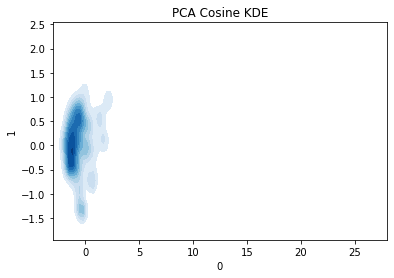

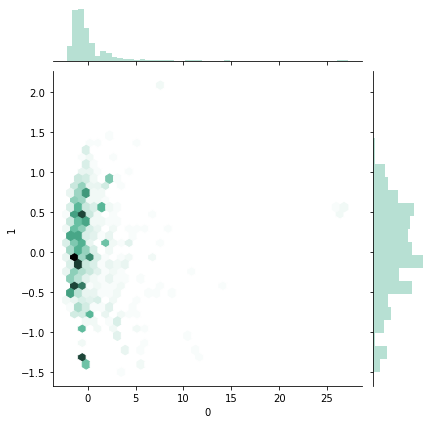

In [26]:
pca = PCA(n_components=20)
principalComponents = pca.fit_transform(cosine) #replace with cosine or clust_df

PCA_components = pd.DataFrame(principalComponents)
PCA_components["Company"] = corpus["Company"]
PCA_components["Location"] = corpus["Location"]
PCA_components["State"] = corpus["State"]
PCA_components["Summary"] = corpus["Summary"]
PCA_components["Size"] = 1

import seaborn as sns
import matplotlib.pyplot as plt

ax = sns.kdeplot(PCA_components[0], PCA_components[1], shade=True, cmap = 'Blues',shade_lowest=False).set(title="PCA Cosine KDE")
ax = sns.jointplot(PCA_components[0], PCA_components[1], kind="hex", color="#4CB391")

### The PCA search and summarize function:

In [12]:
from gensim.summarization import summarize
from tqdm import tqdm

def area_search_function(x_min,x_max,y_min,y_max,df):
    summary = ""
    df_t = df[(df[0] > x_min) &
            (df[0] < x_max) &
            (df[1] > y_min) &
            (df[1] < y_max)]
    all_desc = df_t["Summary"]
    for desc in tqdm(all_desc):
        try:
            summary = summary + desc
        except:
            print(desc)
    return summary

summary_pinpoint = area_search_function(-1,1,-0.5,-0.1,PCA_components)
summary_pinpoint = summarize(summary_pinpoint,word_count=200)
print(summary_pinpoint)

100%|███████████████████████████████████████████████████████████████████████████████| 81/81 [00:00<00:00, 81141.30it/s]


Manage and consolidate all Operational Spreadsheets.Work with management to prioritize business and information needs.Locate and define new process improvement opportunities.Collaborating with the executive team to understand the analytical needs of our multichannel operations and developing data-driven insights that are both strategic and operational.Formulating and championing insights on specific business tactics such as inventory forecasting and gaps analysis to drive those insights into action.What You Need to Succeed:-  to  years of experience working in Inventory Analyst role or Warehouse Master Data Management.- Bachelor's degree or higher education in Computer Science, Information Technology, Statistics, Business Administration or a closely related field.- Sound knowledge of inventory control practices & supply chain- Advanced Excel spreadsheet knowledge: Pivot Table, VLOOKUP, Various Formula- Familiarity with SAP and Warehouse Management System is a plus.Other Skills:-Excepti

### Let's explore structured extraction using spaCy

In [21]:
import spacy
import en_core_web_sm
from spacy import displacy

# load en_core_web_sm of English for vocabluary, syntax & entities
nlp = en_core_web_sm.load()

sentence= "This position will be the first of its kind at Fair Harbor and as such, the person in this role must be able and excited to take full responsibility for building out and maintaining internal tracking and reporting procedures"

processed_sentence = nlp(sentence)

displacy.render(processed_sentence, style="dep", jupyter= True)

In [22]:
displacy.render(processed_sentence, style = "ent",jupyter = True)

### Function to find entity pairs and relationships

In [23]:
from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm

def get_entities(sent):
  # credit to https://www.analyticsvidhya.com/blog/2019/10/how-to-build-knowledge-graph-text-using-spacy/
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  #############################################################
  
  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
  #############################################################

  return [ent1.strip(), ent2.strip()]

def get_relation(sent):

  doc = nlp(sent)

  # Matcher class object 
  matcher = Matcher(nlp.vocab)

  #define the pattern 
  pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

  matcher.add("matching_1", None, pattern) 

  matches = matcher(doc)
  k = len(matches) - 1

  span = doc[matches[k][1]:matches[k][2]] 

  return(span.text)

### Lastly, we visualize in a network graph

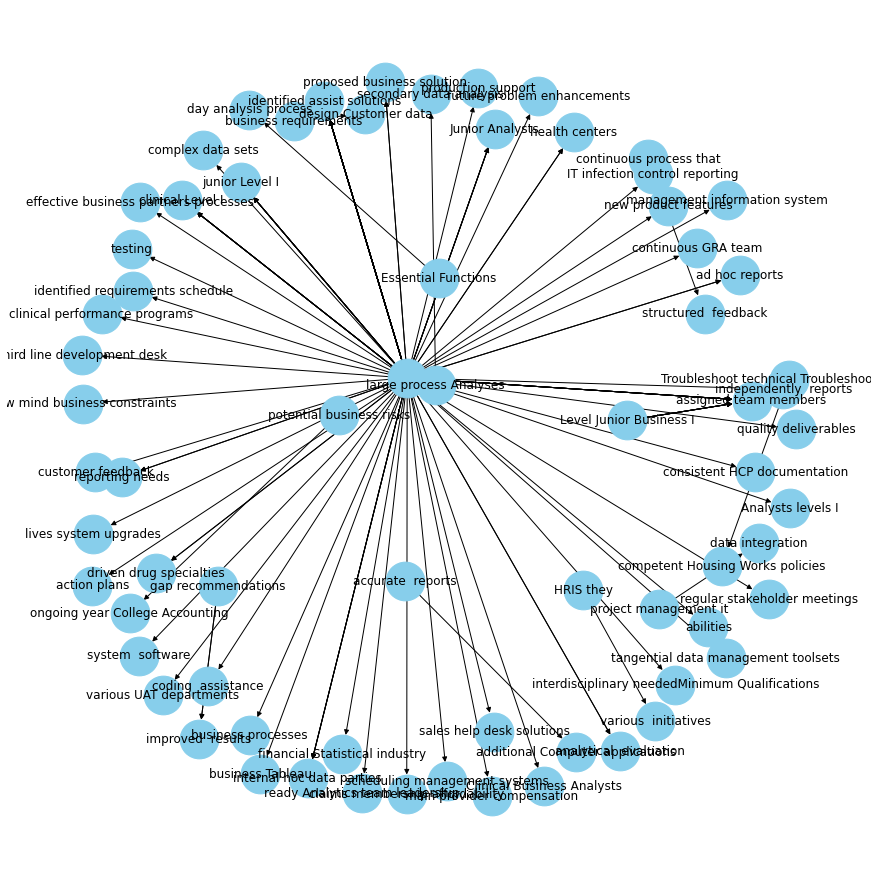

In [25]:
entity_pairs = []

#create list with all sentences
tokens = corpus["Summary"].apply(lambda x: sent_tokenize(x))
all_sent = []
for token in tokens:
    all_sent.extend(token)

for i in all_sent:
  entity_pairs.append(get_entities(i))

relations = [get_relation(i) for i in all_sent]

top_relations=pd.Series(relations).value_counts()

# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="Provide"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()